[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neurogym/ngym_usage/blob/master/supervised/auto_notebooks/supervised/PerceptualDecisionMaking-v0.ipynb)

# Recurrent Neural Networks

Index:

- Installs, packages, auxiliary functions.
- Preparing for the training:
- Supervised training of the RNN.
- Network analysis:
    - Behavioral analysis.

## 0. Installs, packages, auxiliary functions

### 0.1. Helper functions

We first download the helper modules from the [BAMB2024 Github repository](https://github.com/bambschool/BAMB2024). Just execute the code in the cells below and see if it populates the modules locally and ensure that there are no installation errors.


In [1]:
# define the github path and authorization token
RAW_GITHUB_PATH = 'https://raw.githubusercontent.com/bambschool/BAMB2023/main/4-recurrent_neural_networks/'

# define the list of files to be downloaded
files = ['data.py', 'ops.py']

for file in files:
    result = !wget -O {file} "{RAW_GITHUB_PATH}{file}"
# List the files in the current directory to verify
!ls -l

total 16
-rw-r--r-- 1 root root 5910 Jul 21 09:02 data.py
-rw-r--r-- 1 root root  341 Jul 21 09:02 ops.py
drwxr-xr-x 1 root root 4096 Jul 18 13:22 sample_data


### 0.2. Neurogym

We will use the toolbox [**Neurogym**](https://github.com/neurogym/neurogym/) to define the tasks that our RNNs will have to learn.

**NeuroGym** is a curated collection of neuroscience tasks with a common interface. It's main goal is to facilitate training of neural network models on neuroscience tasks.

In [2]:

# Uncomment following lines to install
! pip install gym   # Install gym
! git clone https://github.com/gyyang/neurogym.git  # Install neurogym
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 11100, done.
remote: Counting objects: 100% (273/273), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 11100 (delta 132), reused 222 (delta 108), pack-reused 10827
Receiving objects: 100% (11100/11100), 8.20 MiB | 21.05 MiB/s, done.
Resolving deltas: 100% (8318/8318), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793126 sha256=ed1f52a5ae3d0b078ff5aeed75478d99d45e3381f5958a480aa713b0ffe3a45e
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built gym
  Attempting uninstall: gym
    Found existing installation

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1Suk5bvKiFqZCmIu4f1pWNghBxrznJ0U_" alt="drawing" width="1000"/>
</p>

### 0.3. Imports

Import the packages we need for training and analyzing the RNNs. Especially, we will use the toolbox [pytorch](https://pytorch.org/) to define and train the networks.

In [3]:
# packages to save data
import os
from pathlib import Path
import json

# packages to handle data
import numpy as np
import pandas as pd


# packages to visualize data
import matplotlib.pyplot as plt
import matplotlib as mpl

# import torch and neural network modules to build RNNs
import torch
import torch.nn as nn

# import gym and neurogym to create tasks
import gym
import neurogym as ngym
from neurogym.utils import plotting

# import
import data
import ops

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


## 1. Preparing for the training

We will first set some parameters for the training.

Then we will focus on the 3 important decisions one has to make before training the network:
- Define the task.
- Define the network.
- Define the algorithm to train the network.

### 1.1. Define the training parameters

In [4]:
# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# INSTRUCTION 19 (once you have finished the tutorial): Other tasks to try: 'DelayMatchSample-v0', 'GoNogo-v0', 'ContextDecisionMaking-v0'
# Set up config:
training_kwargs = {'dt': 100,
                   'lr': 1e-2,
                   'n_epochs': 8000,
                   'batch_size': 16,
                   'seq_len': 100}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 1.2. Define task

In [5]:
# Set up task parameters
envid = 'PerceptualDecisionMaking-v0' # name of the task on the neurogym library
if envid == 'PerceptualDecisionMaking-v0':
    env_kwargs = {'dt': training_kwargs['dt'],
                'timing': {'fixation': 300,
                            'stimulus': 500,
                            'delay': 0,
                            'decision': 100},
                'sigma': 1,
                'dim_ring': 2}
    wrappers_kwargs = {'probs': [[0.8, 0.2], [0.2, 0.8]], 'block_dur': 50}
else:
    env_kwargs = {'dt': training_kwargs['dt']}

#### 1.2.1. Sample dataset

In [6]:
# call function to sample
_, env = data.get_dataset(envid=envid, env_kwargs=env_kwargs, wrappers_kwargs=wrappers_kwargs, training_kwargs=training_kwargs)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


We now zoom out and plot the ground truth and the blocks, to see how the task is structured.

### 1.3. Define network

In [10]:
# Set up config:
num_neurons = 64

net_kwargs = {'hidden_size': num_neurons,
              'action_size': env.action_space.n,
              'input_size': env.observation_space.shape[0]} # size of the input to the network
# Define network instance
net = ops.RLNet(input_size=env.observation_space.shape[0],
                hidden_size=net_kwargs['hidden_size'],
                output_size=env.action_space.n)
# Faster alternative: import ops.efficieNet as Net and do net = Net(input_size=env.observation_space.shape[0],...
# efficieNet is the same implementation as Net but using PyTorch's built-in RNN module
# Move network to the device (CPU or GPU)
net = net.to(device)

### 1.4. Define the algorithm to train the network



In [13]:
# Define loss: instance of the CrossEntropyLoss class
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=training_kwargs['lr'])

### 1.5. Save config

In [14]:
training_kwargs['env_kwargs'] = env_kwargs
training_kwargs['net_kwargs'] = net_kwargs

# Save config
with open(ops.get_modelpath(envid) / 'config.json', 'w') as f:
    json.dump(training_kwargs, f)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2. Supervised training of the RNN

In [ ]:
def run_RL_sim(net, env, num_steps):
    actions = []
    gt = []
    action = env.action_space.sample() # sample a random action from the action space
    ob, rew, _, info = env.step(action)
    for _ in range(int(num_steps)):
        # concatenate ob with reward and action
        ob = np.concatenate([ob, [rew], [action]])
        # read out the inputs in that trial
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        action_pred, _ = net(inputs)
        action_pred = action_pred.numpy()
        action = np.argmax(action_pred[:, 0, :], axis=1)
        # You can also try to set the action to one constant value, e.g. action = 1
        ob, rew, _, info = env.step(action)
        actions.append(action)
        gt.append(info['gt'])
    return actions, gt

In [15]:
print('Training task ', envid)

num_epochs = training_kwargs['n_epochs']
num_steps = training_kwargs['seq_len']
# We'll keep track of the loss as we train.
# It is initialized to zero and then monitored over training interations
running_loss = 0.0

for i in range(num_epochs):

    # get inputs and labels and pass them to the GPU
    actions, ground_truth = run_RL_sim(net, env, num_steps)
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
    # print shapes of inputs and labels
    if i == 0:
        print('inputs shape: ', inputs.shape)
        print('labels shape: ', labels.shape)
        print('Max labels: ', labels.max())
    # we need zero the parameter gradients to re-initialize and avoid they accumulate across epochs
    optimizer.zero_grad()

    # INSTRUCTION 3: FORWARD PASS: get the output of the network for a given input
    outputs, _ = net(inputs)

    #reshape outputs so they have the same shape as labels
    outputs = outputs.view(-1, env.action_space.n)

    #  INSTRUCTION 4: compute loss with respect to the labels
    loss = criterion(outputs, labels)

    # INSTRUCTION 5: compute gradients
    loss.backward()

    # INSTRUCTION 6: update weights
    optimizer.step()

    # print average loss over last 200 training iterations and save the current network
    running_loss += loss.item()
    if i % 200 == 199:
        print('{:d} loss: {:0.5f}'.format(i + 1, running_loss / 200))
        running_loss = 0.0

        # save current state of network's parameters
        torch.save(net.state_dict(), ops.get_modelpath(envid) / 'net.pth')

print('Finished Training')

Training task  PerceptualDecisionMaking-v0
inputs shape:  torch.Size([100, 16, 3])
labels shape:  torch.Size([1600])
Max labels:  tensor(2)
200 loss: 0.39359
400 loss: 0.14278
600 loss: 0.10490
800 loss: 0.09161
1000 loss: 0.08593
1200 loss: 0.08294
1400 loss: 0.08122
1600 loss: 0.08016
1800 loss: 0.07937
2000 loss: 0.07884
2200 loss: 0.07849
2400 loss: 0.07815
2600 loss: 0.07793
2800 loss: 0.07777
3000 loss: 0.07759
3200 loss: 0.07746
3400 loss: 0.07741
3600 loss: 0.07729
3800 loss: 0.07722
4000 loss: 0.07719
4200 loss: 0.07711
4400 loss: 0.07706
4600 loss: 0.07706
4800 loss: 0.07700
5000 loss: 0.07697
Finished Training


## 3. Run the trained network
### (and save the behavioral data)

We will now run the network that we have trained. Importantly, we will record the activity of the network and the task variables for the analysis.

In [16]:
# load configuration file - we might have run the training on the cloud and might now open the results locally
with open(ops.get_modelpath(envid) / 'config.json') as f:
    config = json.load(f)

Now, we'll make a new instance of the `Net` class and populate it with hyperparameters from our config file, as well as the trained weights.

In [17]:
# Since we will not train the network anymore, we can turn off the gradient computation. The most commun way to do this is to use the context manager torch.no_grad() as follows:
with torch.no_grad():
    net = Net(input_size=config['net_kwargs']['input_size'],
              hidden_size=config['net_kwargs']['hidden_size'],
              output_size=config['net_kwargs']['action_size'])

    net = net.to(device) # pass to GPU for running forwards steps

    # load the trained network's weights from the saved file
    net.load_state_dict(torch.load(ops.get_modelpath(envid) / 'net.pth'))

    # how many trials to run
    num_trial = 1000

    # empty lists / dataframe to store activity, choices, and trial information
    activity = []
    obs = []
    actions = []
    gt = []
    perf = []
    info = pd.DataFrame()

    for i in range(num_trial):

        # create new trial
        env.new_trial()

        # read out the inputs in that trial
        inputs = torch.from_numpy(env.ob[:, np.newaxis, :]).type(torch.float)
        # as before you can print the shapes of the variables to understand what they are and how to use them
        # do this for the rest of the variables as you build the code
        if i == 0:
            print('Shape of inputs: ' + str(inputs.shape))
        # INSTRUCTION 7: get the network's prediction for the current input
        action_pred, hidden = net(inputs)
        action_pred = action_pred.numpy()

        # INSTRUCTION 8: get the network's choice.
        # Take into account the shape of action_pred. Remember that the network makes a prediction for each time step in the trial.
        # Which is the prediction we really care about when evaluating the network's performance?
        choice = np.argmax(action_pred[:, 0, :], axis=1)
        # INSTRUCTION 9: check if the choice is correct
        # Again, which is the target we want when evaluating the network's performance?
        correct = choice[-1] == env.gt[-1]

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice[-1], 'block': env.curr_block}) # Update trial_info with additional information
        info = pd.concat([info, pd.DataFrame([trial_info])], ignore_index=True)

        # Log activity
        activity.append(np.array(hidden)[:, 0, :])

        # Log the inputs (or observations) received by the network
        obs.append(env.ob)
        actions.append(choice)
        gt.append(env.gt)
        perf.append(choice == env.gt)


    print('Average performance', np.mean(info['correct']))

activity = np.array(activity)
obs = np.array(obs)
print(obs.shape)
print(actions[0])
ops.plot_trials_timestep(inputs=obs[0], actions=actions[0], gt=gt[0], perf=perf[0], env_kwargs=env_kwargs)   
# print stats of the activity: max, min, mean, std
print('Activity stats:')
print('Max: ' + str(np.max(activity)) + \
      ', Min: ' + str(np.min(activity)) + \
      ', Mean: ' + str(np.mean(activity)) + \
      ', Std: ' + str(np.std(activity)) + \
        ', Shape: ' + str(activity.shape))

Shape of inputs: torch.Size([9, 1, 3])
Average performance 0.49
Activity stats:
Max: 1.6003311, Min: 0.0, Mean: 0.25122955, Std: 0.45956355, Shape: (1000, 9, 64)


### 4. Network analysis

#### 4.1. Behavioral analysis

First, we will do a simple analysis of the network's behavior. Will the network behave similarly to a human participant? We have seen above that its average fraction of correct is at ~ 0.8-0.9. Let's now calculate the psychometric curve, i.e., performance by evidence levels. Use the `info` dataframe as if it was behavioral data from a participant.

In [18]:
# print the variables in the info dataframe
print('Info dataframe:')
print(info.head())

Info dataframe:
   ground_truth   coh  correct  choice  block
0             1  25.6    False       1      0
1             1  51.2    False       1      0
2             1   6.4    False       1      0
3             1  51.2    False       1      0
4             0   6.4     True       1      0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Plot the psychometric curve. You can use the function you wrote in the first tutorial.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


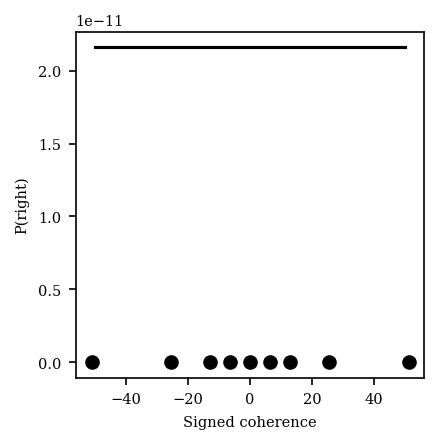

In [19]:
# plot the probability of choosing right as a function of the signed coherence and then fit a psychometric curve to the data.
mpl.rcParams['font.family'] = ['DejaVu Serif']
from scipy.optimize import curve_fit
block_colors = ['m', 'c']
def plot_psychometric_curve(info):
    f, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)
    choice = info['choice'].values
    # translate choice to 0 and 1
    choice_01 = np.copy(choice)
    choice_01 -= 1
    gt = info['ground_truth'].values
    coherence = info['coh'].values
    # get signed coherence
    signed_coherence = np.copy(coherence)
    signed_coherence[gt == 0] = -signed_coherence[gt == 0]
    block = info['block'].values

    for i_blk, blk in enumerate(np.unique(block)):
        idx = block == blk
        print(blk)
        # filter trials by block
        choice_01_block = choice_01[idx]
        signed_coherence_block = signed_coherence[idx]
        # INSTRUCTION 10: plot the probability of choosing right as a function of the signed coherence
        for sc in np.unique(signed_coherence_block):
            prob_right = np.mean(choice_01_block[signed_coherence_block == sc])
            std_right = np.std(choice_01_block[signed_coherence_block == sc])/np.sqrt(np.sum(signed_coherence_block == sc))
            ax.errorbar(sc, prob_right, yerr=std_right, color=block_colors[i_blk])
            ax.plot(sc, prob_right, 'o', color='k')
            ax.set_xlabel('Signed coherence')
            ax.set_ylabel('P(right)')
        # fit psychometric curve
        pars, _ = curve_fit(ops.probit, signed_coherence_block, choice_01_block, p0=[0, 1])
        x = np.linspace(-50, 50, 100)
        ax.plot(x, ops.probit(x, *pars), color=block_colors[i_blk], label='Block ' + str(blk) + ' slope: ' + str(np.round(pars[1], 2)))
    plt.legend()
    plt.show()
plot_psychometric_curve(info)

#### 4.2. neural analysis

We will now inspect the network actity and observations. `activity` is of shape (100, 24, 64) (`[ntrials x ntime x nneurons]`), and observations of shape (100, 24, 3) (`[ntrials x ntime x nobs]`).

##### Plot an example trial

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


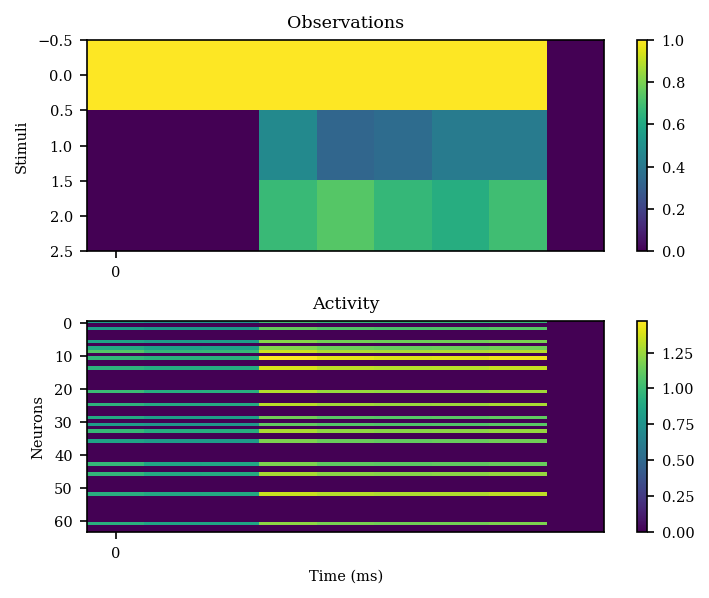

In [20]:
def plot_activity(activity, obs, config, trial):

    # Load and preprocess results
    f, ax = plt.subplots(figsize=(5, 4), nrows=2, dpi=150)

    # time in ms
    t_plot = np.arange(activity.shape[1]) * config['dt']

    # plot the observations for one trial. Note that we will visualize the inputs as a matrix instead of traces, as we have done before.
    im = ax[0].imshow(obs[trial].T, aspect='auto', vmin=0, vmax=1)
    ax[0].set_title('Observations')
    ax[0].set_ylabel('Stimuli')

    # change the xticks to show time in ms
    ax[0].set_xticks(np.arange(0, activity.shape[1], 10))
    ax[0].set_xticklabels(t_plot[::10])
    plt.colorbar(im, ax=ax[0])
    # INSTRUCTION 11: plot the activity for one trial
    im = ax[1].imshow(activity[trial].T, aspect='auto', cmap='viridis')
    ax[1].set_title('Activity')
    ax[1].set_xlabel('Time (ms)')
    ax[1].set_ylabel('Neurons')
    plt.colorbar(im, ax=ax[1])
    # change the xticks to show time in ms
    ax[1].set_xticks(np.arange(0, activity.shape[1], 10))
    ax[1].set_xticklabels(t_plot[::10])

    plt.tight_layout()

plot_activity(activity=activity, obs=obs, config=config, trial=0)

You can see that many neurons are completely silent. Is this always like this? Let's identify and exclude the silent neurons.

fraction of silent neurons: 0.734375


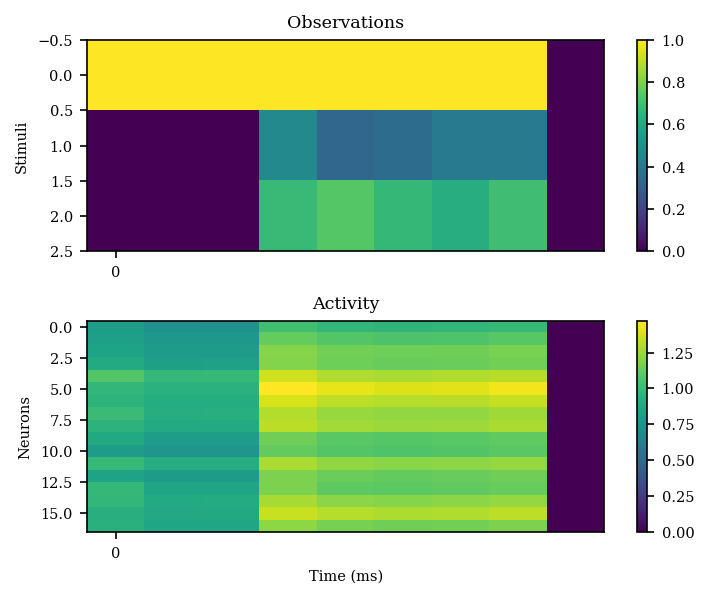

In [21]:
silent_idx = np.where(activity.sum(axis=(0, 1))==0)[0]

print('fraction of silent neurons:', len(silent_idx)/activity.shape[-1])
# INSRTUCTION 12: plot the activity for one trial, but now excluding the silent neurons
clean_activity = activity[:,:,np.delete(np.arange(activity.shape[-1]), silent_idx)]
plot_activity(activity=clean_activity, obs=obs, config=config, trial=0)

 You see that 50% of the neurons are silent. Why do you think this happens?

 Also, as in biological networks, the active units of the RNN have different levels of activity. We will thus normalize the acitvity across all trials (so that all neurons have the same minimum and maximum activity) and plot again.

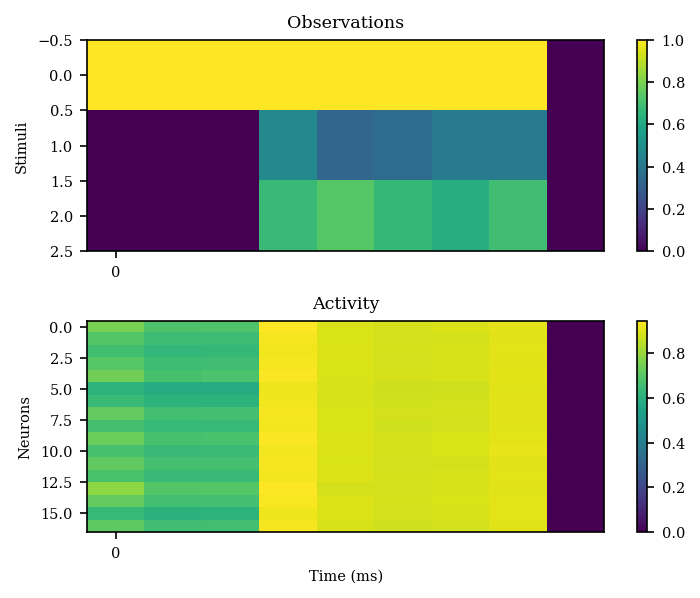

In [22]:
# min_max scaling
minmax_activity = np.array([neuron-neuron.min() for neuron in clean_activity.transpose(2,0,1)]).transpose(1,2,0)
minmax_activity = np.array([neuron/neuron.max() for neuron in minmax_activity.transpose(2,0,1)]).transpose(1,2,0)

plot_activity(activity=minmax_activity, obs=obs, config=config, trial=0)

We can see that neurons have mixed activtity profiles, corresponding to the different task periods. Can you figure out the role played by some of these neurons?

#### Plot Peristimulus histograms for the different choices

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ground_truth   coh  correct  choice  block
0               1  25.6    False       1      0
1               1  51.2    False       1      0
2               1   6.4    False       1      0
3               1  51.2    False       1      0
4               0   6.4     True       1      0
..            ...   ...      ...     ...    ...
995             1   0.0    False       1      0
996             0   6.4     True       1      0
997             1   6.4    False       1      0
998             0   0.0     True       1      0
999             0   0.0     True       1      0

[1000 rows x 5 columns]


TypeError: 'Axes' object is not subscriptable

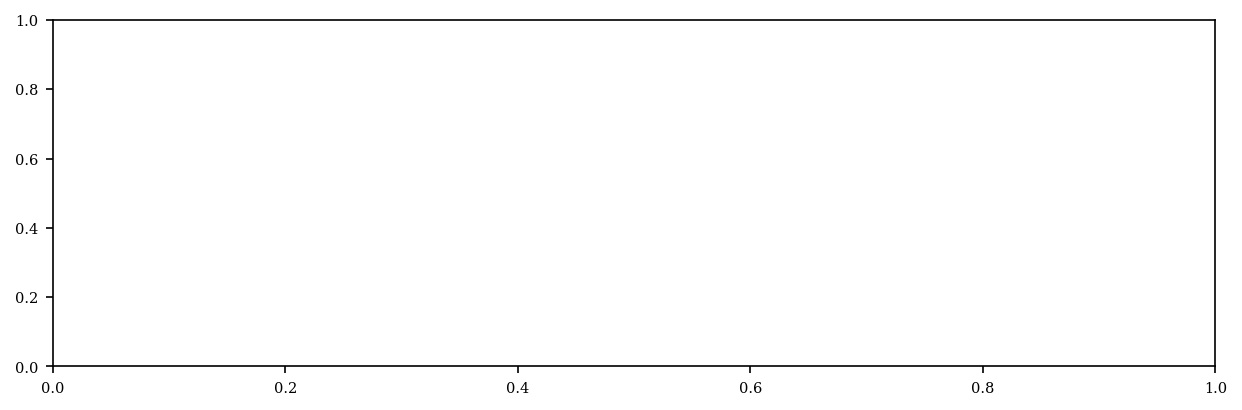

In [25]:
def analysis_activity_by_condition(activity, info, config, conditions=['choice']):
    """
    Plot single neuron activity by condition.
    """
    for condition in conditions:
        values = pd.unique(info[condition])
        print(info)
        f, ax = plt.subplots(figsize=(10, 3), ncols=len(values), sharex=True, dpi=150)
        t_plot = np.arange(activity.shape[1]) * config['dt']
        for i_v, value in enumerate(values):
            # INSTRUCTION 13: plot the average activity across neurons and trials for each condition
            a = activity[info[condition] == value]
            ax[i_v].imshow(a.mean(axis=0).T, aspect='auto', cmap='viridis')
            ax[i_v].set_xlabel('Time (ms)')
            ax[i_v].set_ylabel('Mean activity for ' + condition + ' = ' + str(value))
            # change the xticks to show time in ms
            ax[1].set_xticks(np.arange(0, activity.shape[1], 10))
            ax[1].set_xticklabels(t_plot[::10])

        # plt.legend(title=condition, loc='center left', bbox_to_anchor=(1.0, 0.5))

analysis_activity_by_condition(minmax_activity, info, config, conditions=['choice']) # other conditions: correct, ground_truth

As you can see, there are neurons that are more active for one choice than for the other. And others are active for both, what do you think they are doing?

### 4.3. Stimulus and choice decoding from hidden unit activity

We will now look at the information content in the hidden layers: How long does it take (after stimulus presentation) until the RNN represents stimuli reliably? We are going to use linear discriminant analysis (`sklda.LinearDiscriminantAnalysis`), which is a simple linear classifier.

For each time bin, we will divide the `ntrials x nneurons` activity matrix, as well as the `ntrials` vector of labels (`info.ground_truth.values`) into a train and test set by calling `sklms.train_test_split()`. We will then fit LDA weights on the train set, and predict labels (left vs. right) from the test set activity to calculate the classification accuracy.

Repeat that procedure for 100 train-test-splits to calculate the mean classification accuracy for each timepoint, as well as 95% confidence intervals over train-test-splits.

In [ ]:
import sklearn.model_selection as sklms
import sklearn.discriminant_analysis as sklda

In [ ]:
# number of CV splits
n_splits = 100

# set
mean_acc = np.zeros([n_splits, minmax_activity.shape[1]]) * np.nan

for i in range(n_splits):

    # transpose tensor to be shape [trials, time, neurons]
    for xi,x in enumerate(minmax_activity.transpose(1,0,2)):

        # INSTRUCTION 14: split data into train and test sets using sklms.
        x_train, x_test, y_train, y_test = sklms.train_test_split(x, info.ground_truth.values, random_state=i)

        # INSTRUCTION 15: fit a linear discriminant analysis model to the training data using sklda
        lda_fitted = sklda.LinearDiscriminantAnalysis(solver='lsqr').fit(X=x_train, y=y_train)

        # INSTRUCTION 16: predict the labels for the test data
        y_pred = lda_fitted.predict(x_test)

        # INSTRUCTION 17: compute the accuracy of the model
        correct = 1 - np.abs(y_pred - y_test)

        mean_acc[i,xi] = correct.mean()

In [ ]:
# calculate 95% CI
ci_acc = np.percentile(mean_acc, [5,95], axis=0)

Plot the classification accuracy (together with the 95% CI) over the course of time.

In [ ]:
# for plotting: time axis, stim and resp times
t_plot = np.arange(activity.shape[1]) * config['dt']
stim_onset = t_plot[np.where(obs[0,:,1]!=0)[0][0]]
resp_onset= t_plot[np.where(obs[0,:,0]!=1)[0][0]]

# plot linear classification accuracy
plt.figure(figsize=(4,3), dpi=150)
plt.plot(t_plot, np.zeros(mean_acc.shape[1])+.5, 'k--', alpha=.2)
plt.plot(stim_onset, .48, '^', color = 'r', ms=10)
plt.plot(resp_onset, .48, '^', color='b', ms=10)
plt.plot(t_plot, np.mean(mean_acc, axis=0), 'k')
plt.fill_between(t_plot, ci_acc[0], ci_acc[1], color='k', alpha=.2)
plt.ylabel('classification accuracy')
plt.xlabel('time')
plt.xlim(t_plot[0],t_plot[-1])

We can see that before stimulus presentation, classification accuracy is at chance. In contrast, information about the stimulus rises quickly after.

Will these network dynamics look different for stimuli of different coherence levels? Repeat the same analysis for each level of coherence (`info.coh.values`) and plot the mean accuracy with the pre-specified color gradient. To keep the plot clean, skip confidence intervals.

In [ ]:
mean_acc = np.zeros([len(np.unique(info.coh.values)), n_splits, minmax_activity.shape[1]])

for ci,c in enumerate(np.unique(info.coh.values)):

    # INSTRUCTION 18: get the indices of the trials with the current coherence
    cidx = np.where(info.coh.values==c)

    for i in range(n_splits):

        # transpose tensor to be shape [trials, time, neurons]
        for xi,x in enumerate(minmax_activity[cidx].transpose(1,0,2)):

            # train-test-split
            x_train, x_test, y_train, y_test = sklms.train_test_split(x, info.ground_truth.values[cidx], random_state=i)

            # fit to train data
            lda_fitted = sklda.LinearDiscriminantAnalysis(solver='lsqr').fit(X=x_train, y=y_train)

            # predict test set labels
            y_pred = lda_fitted.predict(x_test)

            # is the response correct for each trial?
            correct = 1 - np.abs(y_pred - y_test)

            mean_acc[ci,i,xi] = correct.mean()

In [ ]:
# colors corresponding to different values of color gradient
colors = plt.get_cmap('magma')(np.linspace(0.1,.9, len(np.unique(info.coh.values))))

# plot linear classification accuracy
plt.figure(figsize=(4,3), dpi=120)

# plot mean acc for each coherence level
for ci in range(len(np.unique(info.coh.values))):
    plt.plot(t_plot, np.mean(mean_acc[ci], axis=0), color=colors[ci], label=np.unique(info.coh.values)[ci])

plt.plot(t_plot, np.zeros(mean_acc[ci].shape[1])+.5, 'k--', alpha=.2)
plt.plot(stim_onset, .48, '^', color = 'k', ms=10)
plt.plot(resp_onset, .48, '^', color='k', ms=10)
plt.ylabel('classification accuracy')
plt.xlabel('time')
plt.xlim(t_plot[0], t_plot[-1])
plt.legend(frameon=False)

In [ ]:
env.reset()